In [81]:
import pandas as pd
import os
import re
import numpy as np
import math
import geojson
import matplotlib.pyplot as plt
import math

In [82]:
path = os.getcwd()
path = path.split('CIS550_Group_Project')[0]

# Listing Data

### (1)Read in data

In [83]:
l1 = pd.read_csv(path + 'data/listings.csv')

In [84]:
len(pd.unique(l1['neighbourhood']))

209

### (2)Generate Summary Statistics

In [85]:
#summaryStats = l1.describe()
#summaryStats.to_csv('data/listing_summary_stats.csv')

### (3)Subset Useful Columns

In [86]:
useful_columns = ['id', 'listing_url', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_picture_url',
       'host_listings_count',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 
       'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable']
l2 = l1[useful_columns]

### (4)Convert bathroom_text column to bathrooms column(numeric)

In [87]:
#l2['bathrooms'] = l2['bathrooms_text'].astype(str).apply(lambda x: x.split(' ')[0] if len(x.split(' ')) > 0 else None)

In [88]:
def extract_bathroom(x):
    blist = str(x).split(' ')
    if len(blist) > 0:
        try:
            float(blist[0])
            return float(blist[0])
        except ValueError:
            if 'half' in str(x).lower():
                return 0.5
    return None

l2['bathrooms'] = l2['bathrooms_text'].apply(extract_bathroom)
l2 = l2.drop(columns=['bathrooms_text'])

<ipython-input-88-11ae1bb7fdc9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l2['bathrooms'] = l2['bathrooms_text'].apply(extract_bathroom)


### (5) Convert Price column to numeric

In [89]:
l2['price'] = l2['price'].str.replace('$','').str.replace(",",'').astype(float)

### (6)rename

In [90]:
l2.rename(columns = {'neighbourhood_cleansed':'neighbourhood', 
                     'neighbourhood_group_cleansed':'neighbourhood_group',
                     'id':'listing_id'}, 
          inplace = True)

In [91]:
### Convert host_since to MySql default date format YYYY-mm-dd
# l2['host_since'] = pd.to_datetime(l2['host_since'], infer_datetime_format=True).astype(str)

### (7)Convert host_response_rate to numeric, remove %

In [92]:
l2['host_response_rate'] = l2['host_response_rate'].str.replace('%','').astype(float)/100

### (8)Convert host_acceptance_rate to numeric, remove %

In [93]:
l2['host_acceptance_rate'] = l2['host_acceptance_rate'].str.replace('%','').astype(float)/100

### (9) Demopose to take host information into host table

In [94]:
host_columns = ['host_id', 'host_url',
       'host_name', 'host_since',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_picture_url',
       'host_listings_count']
host = l2[host_columns]
host.shape

(36724, 10)

In [95]:
# There are 25690 unique host_id
host['host_id'].unique().shape

(25690,)

In [96]:
## after removing duplicates, there are 25690 records for host table
host.drop_duplicates(inplace=True, keep="first") 
host.shape

<ipython-input-96-b9474bdaa677>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  host.drop_duplicates(inplace=True, keep="first")


(25690, 10)

In [16]:
#host.to_csv(path + 'data/host_cleaned.csv', index = False)

### (10) save listing (remove host columns) into csv

In [97]:
listing_removehost_columns = ['listing_id', 'listing_url', 'host_id','name', 'description', 
       'neighborhood_overview', 'picture_url', 
       'neighbourhood', 'neighbourhood_group', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 
       'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable']

In [98]:
l3 = l2[listing_removehost_columns]

In [19]:
#l3.to_csv(path + 'data/listing_removehost_cleaned.csv', index = False)

# Review Data

In [99]:
r1 = pd.read_csv(path + 'data/reviews.csv')

In [100]:
def scan_non_digit(x):
    match = re.findall(r"\D",x)
    if len(match) > 0:
        return ""
    else:
        return x

r1["listing_id"] = r1["listing_id"].astype(str).apply(scan_non_digit)
r1["id"] = r1["id"].astype(int).astype(str).apply(scan_non_digit)

In [101]:
#check problematic id columns
check = r1[(r1['listing_id']== "") | (r1['id']== "") ]
check

,listing_id,id,date,reviewer_id,comments


In [102]:
r1 = r1.drop(columns=['comments'])
r1.rename(columns = {'id': 'review_id'}, 
          inplace = True)

In [103]:
r2 = r1.drop_duplicates(subset = ['review_id'], keep='first')
#r2 = r2.sample(n = 75000)

In [25]:
#r2.to_csv(path + 'data/review_cleaned_sample.csv', index = False)

## Neighborhood Data

In [104]:
def parse_geojson(file_path):
    
    with open(file_path) as f:
        gj = geojson.load(f)
    
        results = []
    
    for record in gj["features"]:
        coord = np.array(record['geometry']['coordinates'][0][0])
        min_coord = list(np.amin(coord,axis=0))
        max_coord = list(np.amax(coord,axis=0))
        results.append({
            "neighbourhood" : record["properties"]["neighbourhood"]
            ,"neighbourhood_group": record["properties"]["neighbourhood_group"]
            ,"minx": min_coord[0]
            ,"maxx": max_coord[0]
            ,"miny": min_coord[1]
            ,"maxy": max_coord[1]
            ,"centerx": (min_coord[0] + max_coord[0])/2
            ,"centery": (min_coord[1] + max_coord[1])/2
           })
    
    return pd.DataFrame(results)

In [105]:
### merge target data with neighborhood data by fuzzy join on neightborhood latitude & longtitude range
def match_region_by_latlong(target_df, nbr_df):
    
    lat = target_df['latitude'].values
    long = target_df['longitude'].values
    
    nbr_latlow = nbr_df['miny'].values
    nbr_lathigh = nbr_df['maxy'].values
    nbr_longlow = nbr_df['minx'].values
    nbr_longhigh = nbr_df['maxx'].values
    
    i, j = np.where((lat[:, None] >= nbr_latlow) & (lat[:, None] <= nbr_lathigh) &
                 (lat[:, None] >= nbr_longlow) & (long[:, None] <= nbr_longhigh))
    
    merge_df = pd.DataFrame(
                np.column_stack([target_df.values[i], nbr_df.values[j]]),
                columns = target_df.columns.append(nbr_df.columns)
                )
    
    merge_df['dist_to_center'] = (merge_df['longitude'] - merge_df['centerx'])**2 + (merge_df['latitude'] - merge_df['centerx'])**2
    
    return merge_df

In [106]:
nbr = parse_geojson(path + 'data/neighbourhoods.geojson')

In [107]:
## some neighbourhood belongs to more than one neighbourhood_group 
nbr[nbr['neighbourhood'].isin(['Bayswater','City Island','Howard Beach'])]

,neighbourhood,neighbourhood_group,minx,maxx,miny,maxy,centerx,centery
0,Bayswater,Queens,-73.773977,-73.766708,40.614878,40.620901,-73.770342,40.617890
2,City Island,Bronx,-73.793508,-73.779927,40.836338,40.858610,-73.786718,40.847474
22,Bayswater,Queens,-73.774172,-73.753458,40.596261,40.614255,-73.763815,40.605258
44,City Island,Bronx,-73.787432,-73.784400,40.858809,40.860477,-73.785916,40.859643
126,Howard Beach,Queens,-73.830413,-73.829889,40.655128,40.655552,-73.830151,40.655340
127,Howard Beach,Queens,-73.863171,-73.826430,40.644134,40.674021,-73.844800,40.659078


In [108]:
#remove duplicate
nbr.drop_duplicates(inplace=True, subset=['neighbourhood'], keep="first") 
nbr.shape

(230, 8)

In [109]:
### double check all listing neighborhood included in this neighborhood dataset
for item in list(pd.unique(l2["neighbourhood"])):
    if item not in list(nbr["neighbourhood"]):
        print(item)

### Assign NeighborHood to Museum

In [110]:
m1 = pd.read_csv(path + 'data/MUSEUM_New_York_cleaned.csv')
m1.shape

(130, 9)

In [111]:
m1['longitude'] = -m1['longitude']

In [112]:
m2 = match_region_by_latlong(m1, nbr)
m2.shape

(1436, 18)

In [113]:
## neighborhoods per Museum
m2.shape[0]/m1.shape[0]

11.046153846153846

In [114]:
m2['dist_to_center'] = m2['dist_to_center'].astype('float')
m2["distance_rank"] = m2.groupby("id")["dist_to_center"].rank(method = "first", ascending=True)
m2 = m2[m2["distance_rank"] <= 1]

In [40]:
#m2.to_csv(path + 'data/MUSEUM_with_nbr.csv', index = False)

### Assign Neighborhood to ArtGallery

In [115]:
a1 = pd.read_csv(path + 'data/ART_GALLERY_New_York_cleaned.csv')
a1.shape

(917, 9)

In [116]:
a1['longitude'] = -a1['longitude']

In [117]:
a2 = match_region_by_latlong(a1, nbr)
a2.shape

(11708, 18)

In [118]:
#neighborhood per ArtGallery
a2.shape[0]/a1.shape[0]

12.767720828789532

In [119]:
a2['dist_to_center'] = a2['dist_to_center'].astype('float')
a2["distance_rank"] = a2.groupby("id")["dist_to_center"].rank(method = "first", ascending=True)
a2 = a2[a2["distance_rank"] <= 1]
a2.shape

(917, 19)

In [46]:
#a2.to_csv(path + 'data/ART_GALLERY_with_nbr.csv', index = False)

### Assign Neighborhood to Park

In [120]:
p1 = pd.read_csv(path + 'data/Park_New_York_cleaned.csv')
p1['longitude'] = -p1['longitude']
p1.shape

(3706, 4)

In [121]:
p2 = match_region_by_latlong(p1, nbr)
p2.shape

(29628, 13)

In [122]:
#neighborhoods per Park
p2.shape[0]/p1.shape[0]

7.994603345925526

In [123]:
p2['dist_to_center'] = p2['dist_to_center'].astype('float')
p2["distance_rank"] = p2.groupby("id")["dist_to_center"].rank(method = "first", ascending=True)
p2 = p2[p2["distance_rank"] <= 1]
p2.shape

(3706, 14)

In [56]:
#p2.to_csv(path + 'data/PARK_with_nbr.csv', index = False)

### Assign Neighborhood to Crime Data

In [124]:
c1 = pd.read_csv(path + 'data/NYPD_Arrest_Data__Year_to_Date_Clean.csv')
c1.shape

(73437, 7)

In [125]:
c2 = match_region_by_latlong(c1, nbr)
c2.shape

(587542, 16)

In [59]:
#c2.to_csv(path + 'data/Crime_with_nbr_full_records.csv', index = False)

In [155]:
##debug### check neighborhood & neighborhoodgroup 

In [126]:
len(pd.unique(c2['neighbourhood']))

230

In [127]:
pd.unique(c2['neighbourhood_group'])

array(['Queens', 'Manhattan', 'Brooklyn', 'Bronx', 'Staten Island'],
      dtype=object)

In [128]:
###neighborhoods per Crime incident
c2.shape[0]/c1.shape[0]

8.000626387243488

In [129]:
c2['dist_to_center'] = c2['dist_to_center'].astype('float')
c2["distance_rank"] = c2.groupby("arrest_key")["dist_to_center"].rank(method = "first", ascending=True)
c2 = c2[c2["distance_rank"] <= 8]
c2.shape

(471612, 17)

In [130]:
len(pd.unique(c2['neighbourhood']))

169

In [131]:
pd.unique(c2['neighbourhood_group'])

array(['Queens', 'Brooklyn', 'Bronx', 'Staten Island', 'Manhattan'],
      dtype=object)

In [132]:
#c2.to_csv(path + 'data/Crime_with_nbr.csv', index = False)
# a crime can contribute to 8 cloest neighborhood's crime points

c2.to_csv(path + 'data/Crime_with_8nbr.csv', index = False)

### Aggregate Crime Level by Neighbourhood

In [133]:
c3 = c2[['law_cat_cd','neighbourhood']]

In [134]:
### assign crime points:
# F = 0.7
# M = 0.2
# Other = 0.1
c3['crime_points'] = np.where(c3['law_cat_cd']== 'F', 0.7, 
                               np.where(c3['law_cat_cd']== 'M', 0.2, 0.1))

<ipython-input-134-6d60814d2540>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c3['crime_points'] = np.where(c3['law_cat_cd']== 'F', 0.7,


In [135]:
# aggregate to neighbourhood level
# there are 169 records
crime_by_nbr = pd.DataFrame(c3.groupby(by=["neighbourhood"]).sum()).reset_index()

### Join Aggregated Neighbourhood Crime Rate with Original Neighbourhood Data

In [136]:
nbr2 = nbr.merge(crime_by_nbr[["neighbourhood","crime_points"]], 
                 left_on = 'neighbourhood', right_on = 'neighbourhood', how = 'left')

In [137]:
# there are 169 neighbourhoods with crime points > 0
# other 230 - 169 neighbourhoods with crime points  = 0
# joining create NAs on these 230 - 169 neighbourhoods, fill NA with 0
nbr2['crime_points'] = nbr2['crime_points'].fillna(0)

### Visuliaze Distribution of Crime Rate

(array([120.,  23.,  14.,  22.,   8.,  12.,   7.,   3.,   7.,   2.,   4.,
          0.,   2.,   1.,   1.,   0.,   1.,   1.,   1.,   1.]),
 array([   0.  ,  349.32,  698.64, 1047.96, 1397.28, 1746.6 , 2095.92,
        2445.24, 2794.56, 3143.88, 3493.2 , 3842.52, 4191.84, 4541.16,
        4890.48, 5239.8 , 5589.12, 5938.44, 6287.76, 6637.08, 6986.4 ]),
 <BarContainer object of 20 artists>)

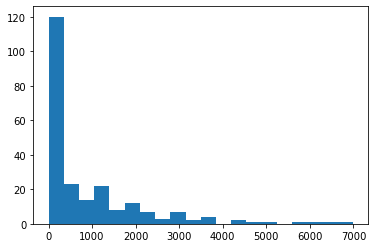

In [138]:
#nbr2['log_crime_points'] = np.log(nbr2['crime_points'] + 1)
plt.hist(nbr2['crime_points'], bins = 20)

In [139]:
nbr2['crime_points'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

0.1       0.00
0.2       0.00
0.3       7.85
0.4      63.80
0.5     258.75
0.6     631.10
0.7    1114.80
0.8    1628.88
0.9    2490.41
Name: crime_points, dtype: float64

### Assign Crime Level and Visualize

In [143]:
def crime_level(x):
    if x == 0:
        return 'A'
    elif x < 65:
        return 'B'
    elif x < 400:
        return 'C'
    elif x < 1000:
        return 'D'
    elif x < 1900:
        return 'E'
    else:
        return 'F'

In [144]:
nbr2['crime_level'] = nbr2['crime_points'].apply(crime_level)

<AxesSubplot:>

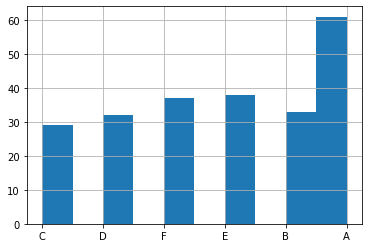

In [145]:
nbr2['crime_level'].hist()

In [147]:
nbr2.to_csv(path + "data/neighbourhoods_add_crime_rate.csv",index = False)